In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import re, os, math, random
from collections import Counter
from collections import defaultdict
import operator
from tqdm import tqdm
import jieba
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix, hstack
from nltk.stem import SnowballStemmer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, Embedding, Bidirectional, CuDNNGRU, CuDNNLSTM, Conv1D, GlobalMaxPooling1D
from keras.layers.merge import concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from tensorflow.python.ops import tensor_array_ops, control_flow_ops
import gc

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Parameters

In [2]:
jieba.enable_parallel(8)
train_corpus = "train_first.csv"
test_corpus = "predict_first.csv"
vocab_path = "Chinese_corpus_dict.vocab"
clean_stop_word = False
vocab_size = 20000
embedding_dims = 300
seq_length = 100
pointer = 0

#####################
## Text RNN
rnn_recurrent_units = 48
rnn_dense_units = 32
rnn_output_units = 5
rnn_batch_size = 256
#####################

#####################
## Text CNN
cnn_filter_nums = 120
cnn_dense_units = 72
cnn_output_units = 5
cnn_batch_size = 256
#####################

#####################
## Hybrid Text NN
hy_recurrent_units = 48
hy_filter_nums = 64
hy_output_units = 5
hy_batch_size = 256
#####################

#####################
## Seq2seq
seq_batch_size = 50
enc_hidden_size = 150
dec_hidden_size = 300
seq_learning_rate = 0.01
start_word = 2    # token number of <SOS>
train_epochs = 10
dropout_keep_prob = 0.75
l2_reg_lambda = 0.2
seq_label_size = 5
#####################

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.550 seconds.
Prefix dict has been built succesfully.


# Data Analysis

In [3]:
train_df = pd.read_csv(train_corpus)
test_df = pd.read_csv(test_corpus)

train_df.sample(100)

,Id,Discuss,Score
76563,c17dde0c-fa61-3797-adee-33682740ecb8,三清山是上饶的一大品牌风景区，建设的不错，绝对值得一游玩。,5
71939,ad389d7a-39ce-39fa-a7c8-16ea787c1a2a,清明假期和我家人一起到桐庐县的金滩景区游玩的 景色确实很美 生态很好 这里比较适合休闲...,4
93943,699f1f38-415c-378a-aa74-d19802598c82,穿越时空的旅行。,4
20603,09dc7552-cd82-3434-9529-a539367efdee,10月去虽然没有了油菜花，但是日出依旧非常美，晚上天空中还有很多星星，就是早晚实在太冷了，穿...,5
67289,cee5b087-9840-3f64-809c-5ff038053c1b,路上经过了温泉群，长白山温泉有“神水”之称，含有大量硫化氢和多种微量元素，有很好的保健效果。,4
69257,6dc314cf-56f2-38ef-85a3-2a2ecf2dbd47,迪士尼乐园一日游,5
56111,4d141f90-0245-3abb-bf2f-54bdec3dbfd7,【点评有奖第12季】五星好评，黄山风景区必须点个赞，强烈推荐！每年的345月份都是出游的好时...,5
33711,c864454e-a5f0-39bd-8e35-892e1b37288c,很雄伟的建筑，众多电影的取景地，很棒,5
57784,08cf8fa0-4a2b-34df-80c3-3d31c58c646a,买票后可以做免费的大巴去天坑又名天生三桥。手机都被我拍照拍没电了…有两个景点可以免费拍照，小...,4
5297,c7f4a492-bc3f-3943-874c-6abe3b2ed519,价格划算，近距离接触小蛮腰,5


In [4]:
label_cols = pd.unique(train_df['Score'])
print(label_cols)

[5 4 3 2 1]


In [5]:
train_df.describe()

,Score
count,100000.000000
mean,4.470010
std,0.752134
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [6]:
test_df.head()

,Id,Discuss
0,9a1caf96-681e-3c11-b588-43ac742d7fd2,快乐之旅
1,82b450db-65c2-351c-84fb-761d76582680,岛上看日落的地方，视野很开阔，非常漂亮
2,2eec4606-590c-3fa2-b846-7f92441c54a6,很有鲁迅风味 很喜欢这样有文化的地方
3,509f9a68-ac41-35ff-9d2e-2fc12f73ed7f,去乌鲁木齐还能不去天山天池吗，哈哈哈～
4,395f4b22-1c5f-328a-a19d-5065e0530cbc,非常满意，直接拿身份证刷机入园就行了，不用排队买票，比较节约时间


In [7]:
# Data length
print("Total rows in train_corpus is {}".format(len(train_df)))
print("Total rows in test_corpus is {}".format(len(test_df)))
print(train_df['Score'].value_counts())

Total rows in train_corpus is 100000
Total rows in test_corpus is 30000
5    60097
4    28954
3     9389
2      973
1      587
Name: Score, dtype: int64


In [8]:
# Sentence length analysis
train_df['Word_Length'] = train_df['Discuss'].apply(lambda x: len(str(x)))
train_df

,Id,Discuss,Score,Word_Length
0,201e8bf2-77a2-3a98-9fcf-4ce03914e712,好大的一个游乐公园，已经去了2次，但感觉还没有玩够似的！会有第三，第四次的,5,37
1,f4d51947-eac4-3005-9d3c-2f32d6068a2d,新中国成立也是在这举行，对我们中国人来说有些重要及深刻的意义！,4,31
2,74aa7ae4-03a4-394c-bee0-5702d3a3082a,庐山瀑布非常有名，也有非常多个瀑布，只是最好看的非三叠泉莫属，推荐一去,4,35
3,099661c2-4360-3c49-a2fe-8c783764f7db,个人觉得颐和园是北京最值的一起的地方，不过相比下门票也是最贵的，比起故宫的雄伟与气势磅礴，颐...,5,61
4,97ca672d-e558-3542-ba7b-ee719bba1bab,迪斯尼一日游,5,6
5,3b7f3f2e-886f-3a68-a810-2c37cfd728d3,方便,4,2
6,88914409-bd13-3d47-b5a2-691177dde8fd,看水看山都可以。感受古人的智慧结晶，秋景美丽如画，红黄绿相间！对于身体状况不佳的人来说，走平...,4,55
7,bf13ec92-6079-3451-ade3-88020cb0dcb5,赞,5,1
8,489c3d94-9c44-3cf2-949c-1b507c374c69,唯一糟点,5,4
9,285bba78-16a3-3c1d-b648-baa483883ee3,周未周边游,5,5


In [9]:
# print(train_df['Word_Length'].value_counts().head())

# For test_data
test_df['Word_Length'] = test_df['Discuss'].apply(lambda x: len(str(x)))
# print(test_df['Word_Length'].value_counts().head())
print(train_df['Word_Length'].describe(), "\n", test_df['Word_Length'].describe())

count    100000.000000
mean         48.283500
std          78.522278
min           1.000000
25%           9.000000
50%          24.000000
75%          52.000000
max        1336.000000
Name: Word_Length, dtype: float64 
 count    30000.000000
mean        49.249733
std         77.584046
min          1.000000
25%         11.000000
50%         25.000000
75%         54.000000
max       1136.000000
Name: Word_Length, dtype: float64


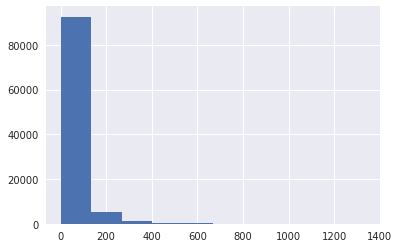

In [10]:
# histogram graph
sns.set()
train_df['Word_Length'].hist()
plt.show()

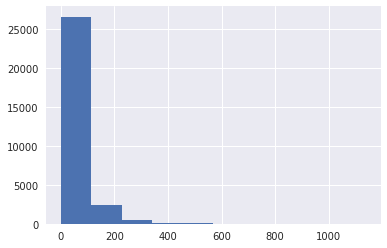

In [11]:
plt.figure()
plt.hist(test_df['Word_Length'])
plt.show()

In [12]:
train_df.sort_values('Word_Length', ascending=False).head(100)['Score'].value_counts()

5    56
4    31
3    12
1     1
Name: Score, dtype: int64

In [13]:
# transform to one-hot
Score = train_df['Score']
data = pd.get_dummies(Score)
train_df = pd.concat([train_df, data], axis=1)
train_df.head()

,Id,Discuss,Score,Word_Length,1,2,3,4,5
0,201e8bf2-77a2-3a98-9fcf-4ce03914e712,好大的一个游乐公园，已经去了2次，但感觉还没有玩够似的！会有第三，第四次的,5,37,0,0,0,0,1
1,f4d51947-eac4-3005-9d3c-2f32d6068a2d,新中国成立也是在这举行，对我们中国人来说有些重要及深刻的意义！,4,31,0,0,0,1,0
2,74aa7ae4-03a4-394c-bee0-5702d3a3082a,庐山瀑布非常有名，也有非常多个瀑布，只是最好看的非三叠泉莫属，推荐一去,4,35,0,0,0,1,0
3,099661c2-4360-3c49-a2fe-8c783764f7db,个人觉得颐和园是北京最值的一起的地方，不过相比下门票也是最贵的，比起故宫的雄伟与气势磅礴，颐...,5,61,0,0,0,0,1
4,97ca672d-e558-3542-ba7b-ee719bba1bab,迪斯尼一日游,5,6,0,0,0,0,1


## Get positive labels

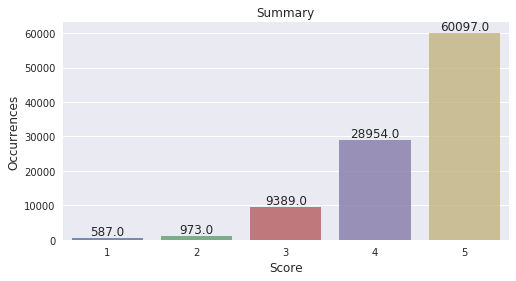

In [14]:
x = train_df.iloc[:, 4:].sum()

plt.figure(figsize=(8, 4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Summary")
plt.ylabel('Occurrences', fontsize=12)
plt.xlabel('Score', fontsize=12)

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, ha='center', va='bottom', s='{:.1f}'.format(abs(label)))
    
plt.show()

## Correlations of labels

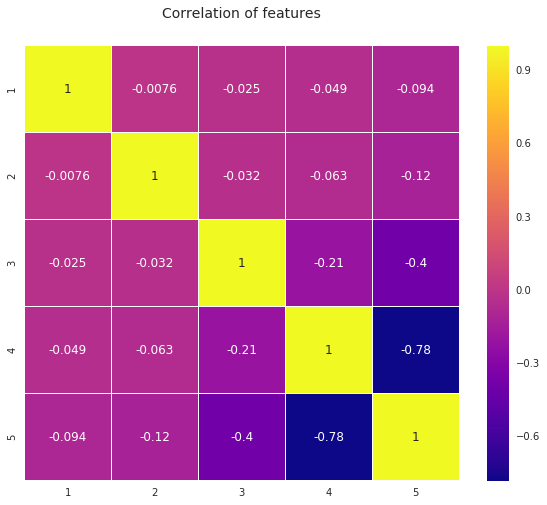

In [15]:
# No sentences contains up to 2 Score-labels
colormap = plt.cm.plasma
plt.figure(figsize=(10, 8))
plt.title('Correlation of features', y=1.05, size=14)
sns.heatmap(data.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

# Processing

In [16]:
def clean_text(text, stem_words=False):
    text = re.sub(r',', '，', text)
    text = re.sub(r'\.+', '...', text)
    text = re.sub(r'\.{6}', '...', text)
    text = re.sub(r'…', '...', text)
    text = re.sub(r';', '；', text)
    text = re.sub(r'°', '。', text)
    text = re.sub(r'】', ']', text)
    text = re.sub(r'【', '[', text)
    text = re.sub(r'\)', '\）', text)
    text = re.sub(r'\(', '\（', text)
    text = re.sub(r'“', '"', text)
    text = re.sub(r' ', '', text)
    text = re.sub(r'”', '"', text)
    text = re.sub(r'～', '~', text)
    text = re.sub(r'·', '。', text)
    text = re.sub(r'!', '！', text)
    text = re.sub(r'—', '-', text)
    text = re.sub(r'》', '\）', text)
    text = re.sub(r'《', '\（', text)
    text = re.sub(r'\?', '\？', text)
    text = re.sub(r'。。。', '...', text)
    text = re.sub(r'。。。。。。', '...', text)
    text = re.sub(r':', '：', text)
    
#     # for English_sentence
#     text = replace_numbers.sub('', text)
#     text = special_character_removal.sub('', text)
#     if stem_words:
#         text = text.split()
#         stemmer = SnowballStemmer('english')
#         stemmed_words = [stemmer.stem(word) for word in text]
#         text = " ".join(stemmed_words)
    
    return text

# regex to remove all Non-Alpha Numeric and space
special_character_removal = re.compile(r'[^a-z\d ]', re.IGNORECASE)

# regex to remove all Alpha Numeric and space
special_alpha_removal = re.compile(r'[a-z\d ]', re.IGNORECASE)

# regex to replace all numeric
replace_numbers = re.compile(r'\d+', re.IGNORECASE)

In [17]:
# Check NaN
print(np.any(train_df.isnull()) == True, np.any(test_df.isnull()) == True)

False False


In [ ]:
# Regular dictionary
print("MSG : Processing text datasets...")
cols_target = [1, 2, 3, 4, 5]

list_sentence_train = train_df['Discuss'].fillna("no discuss").values
train_discusses = [clean_text(text) for text in list_sentence_train]
train_df['Discuss'] = pd.Series(train_discusses).astype(str)

list_sentence_test = test_df['Discuss'].fillna("no discuss").values
test_discusses = [clean_text(text) for text in list_sentence_test]
test_df['Discuss'] = pd.Series(test_discusses).astype(str)

# cleaned_train_discuss = []
# for i in range(len(train_df)):
#     cleaned_discuss = clean_text(train_df['Discuss'][i])
#     cleaned_train_discuss.append(cleaned_discuss)
# train_df['Discuss'] = pd.Series(cleaned_train_discuss).astype(str)

# cleaned_test_discuss = []
# for i in range(len(test_df)):
#     cleaned_discuss = clean_text(test_df['Discuss'][i])
#     cleaned_test_discuss.append(cleaned_discuss)
# test_df['Discuss'] = pd.Series(cleaned_test_discuss).astype(str)
# test_df.head()

MSG : Processing text datasets...


In [ ]:
# Clean up the sentence text & Word segmentation analysis
word_dict = defaultdict(int)

for sentence in tqdm(train_df['Discuss']):
    seg_list = jieba.cut(sentence, cut_all=False)
    for word in seg_list:
        word_dict[word] += 1
word_dict = sorted(word_dict.items(), key=operator.itemgetter(1), reverse=True)
word_dict
print(len(word_dict))

 94%|█████████▍| 93763/100000 [00:41<00:02, 2097.60it/s]

## A quick view of vocabulary

In [ ]:
chinese_list, sign_list, dig_english_list = [], [], []
for word, count in word_dict:
    for char in word:
        if char >= u'\u4E00' and char <= u"\u9FA5":
            chinese_list.append((word, count))
        elif (char >= u'\u0041' and char <= u'\u005A') or (char >= u'\u0061' and char <= u'\u007A') or (char >= u'\u0030' and char <= u'\u0039'):
            dig_english_list.append((word, count))
            break
        else:
            sign_list.append((word, count))
            break
sorted_dig_english_list = sorted(set(dig_english_list), key=lambda x: x[1], reverse=True)
sorted_sign_list = sorted(set(sign_list), key=lambda x: x[1], reverse=True)
sorted_chinese_list = sorted(set(chinese_list), key=lambda x: x[1], reverse=True)
print("chinese_word: ", len(sorted_chinese_list))
print("dig_english_word: ", len(sorted_dig_english_list))
print("sign_count: ", len(sorted_sign_list))
print(sorted_chinese_list[:10000], '\n\n', sorted_dig_english_list[:50], '\n\n', sorted_sign_list[:20])

In [ ]:
# create stop words
chinese_stop_words = [word[0] for word in sorted_chinese_list[vocab_size - 24:]]
english_stop_words = [word[0] for word in sorted_dig_english_list]
sign_stop_words = [word[0] for word in sorted_sign_list[20:]]
stop_words = chinese_stop_words + english_stop_words + sign_stop_words
print(len(stop_words))

In [ ]:
train_df = train_df.drop('Word_Length', axis=1)
train_df

In [ ]:
train_data = train_df.Discuss.values
train_label = train_df['Score'].values
test_data = test_df.Discuss.values
print(train_data.shape, test_data.shape, train_label.shape)

# Data helper

## Build own vocab & data loader

In [ ]:
def build_vocab(vocab_path, data):
    files = open(vocab_path, 'w', encoding='utf-8')
    files.write("{}\t1000000000\n{}\t1000000000\n{}\t1000000000\n{}\t1000000000\n".format("<PAD>", "<UNK>", "<SOS>", "<EOS>"))
    for word, count in data:
        files.write("{}\t{}\n".format(word, count))
        
def mini_batch(vocab_path, data, padding):
    token_seqs, sentences = load_datasets(vocab_path, data, padding)
    num_batch = int(len(sentences) / seq_batch_size)
    token_seqs = token_seqs[:num_batch * seq_batch_size]
    sentences = sentences[:num_batch * seq_batch_size]
    token_batch = np.split(np.array(token_seqs), num_batch, 0)
    sentence_batch = np.split(np.array(sentences), num_batch, 0)
    return token_batch, sentence_batch, num_batch
    
def load_datasets(vocab_path, data, padding=False):
    sentences = [line for line in data if line]
    word2idx, idx2word = load_vocab(vocab_path)
    
    token_list, sources = [], []
    for source in sentences:
        temp_seg = jieba.cut(source, cut_all=False)
        seg_list = [i for i in temp_seg]
        x = [word2idx.get(word, 1) for word in (" ".join(str(i) for i in seg_list) + ' <EOS>').split()]
        if padding:
            if len(x) < seq_length:
                x += [0 for _ in range(seq_length - len(x))]
            else:
                x = x[:100]
        token_list.append(x)
        sources.append(source)
    return token_list, sources
    
def load_vocab(vocab_path):
    vocab = [line.split()[0] for line in open(vocab_path, 'r', encoding='utf-8').read().splitlines()]
    word2idx = {word: idx for idx, word in enumerate(vocab)}
    idx2word = {word2idx[word]: word for word in word2idx}
    return word2idx, idx2word
    
def next_batch(token_batches, sentence_batches, pointer, num_batch):
    result = token_batches[pointer]
    sentence = sentence_batches[pointer]
    pointer = (pointer + 1) % num_batch
    return result, sentence

### Tokenizer

In [ ]:
# Load Dataset
data_series = sorted(sorted_chinese_list[:9976] + sorted_sign_list[:20], key=lambda x: x[1], reverse=True)
build_vocab(vocab_path, data_series)
print("MSG : Finished building vocab file.")

# data tokenize & loaded by mini_batch
token_sequences, sentences, num_batch = mini_batch(vocab_path, train_data, True)
unpad_token_sequences, unpad_sentences, _ = mini_batch(vocab_path, train_data, False)
print("MSG : Finished initialize batch datasets.")

In [ ]:
word2idx, idx2word = load_vocab(vocab_path)
sample_indice = random.randint(0, num_batch)

In [ ]:
print("training set without padded index format: ")
print(unpad_token_sequences[sample_indice][:3], '\n batch_size is: ', len(unpad_token_sequences[sample_indice]))

In [ ]:
print("training set with padded(by zero) index format: ")
print(token_sequences[sample_indice][:3], '\n batch_size is: ', len(token_sequences[sample_indice][1]))
tokens = token_sequences[sample_indice][:3]

In [ ]:
print("training set with padded(by <PAD>) word format: ")
print(sentences[sample_indice][:3], '\n batch_size is: ', len(sentences[sample_indice]))
print("trainslated by tokens: ", [idx2word.get(word, 1) for sent in tokens for word in sent])

In [ ]:
test_token_sequences = load_datasets(vocab_path, test_data, True)

In [ ]:
test_token_sequences, test_sentences, test_num_batch = mini_batch(vocab_path, test_data, True)
print("MSG : Finished initialize batch datasets for prediction.")

In [ ]:
sample_indice_test = random.randint(0, test_num_batch)
print(sample_indice_test)

In [ ]:
print("training set without padded index format: ")
print(test_token_sequences[sample_indice_test][:3], '\n batch_size is: ', len(test_token_sequences[sample_indice_test]))
test_tokens = test_token_sequences[sample_indice_test][:3]

In [ ]:
print("training set with padded(by <PAD>) word format: ")
print(test_sentences[sample_indice_test][:3], '\n batch_size is: ', len(test_sentences[sample_indice_test]))
print("trainslated by tokens: ", [idx2word.get(word, 1) for sent in test_tokens for word in sent])

## Build vocabulary by Keras tools

In [ ]:
# remove alpha numeric & space
list_sentence_train = train_df['Discuss'].values
train_discusses = [special_alpha_removal.sub('', text) for text in list_sentence_train]
train_df['Discuss'] = pd.Series(train_discusses).astype(str)
train_df.head()

In [ ]:
list_sentence_test = test_df['Discuss'].values
test_discusses = [special_alpha_removal.sub('', text) for text in list_sentence_test]
test_df['Discuss'] = pd.Series(test_discusses).astype(str)
test_df.head()

In [ ]:
train_discusses_cut, test_discusses_cut = [], []

for sentence in tqdm(train_discusses):
    seg_list = jieba.cut(sentence, cut_all=False)
    train_discusses_cut.append(" ".join(seg_list))
print("MSG : Segmentation for train_discusses is Done!")

In [ ]:
train_discusses_cut[:3]

In [ ]:
for sentence in tqdm(test_discusses):
    seg_list = jieba.cut(sentence, cut_all=False)
    test_discusses_cut.append(" ".join(seg_list))
print("MSG : Segmentation for test_discusses is Done!")

In [ ]:
# create a tokenizer which transform a sentence to a list of ids
tokenizer = Tokenizer(num_words=vocab_size)

# build the relation between words and ids
tokenizer.fit_on_texts(train_discusses_cut + test_discusses_cut)

# transform training/testing sentences to training/testing sequences
train_sequences = tokenizer.texts_to_sequences(train_discusses_cut)
test_sequences = tokenizer.texts_to_sequences(test_discusses_cut)

word_index = tokenizer.word_index
print("Found {} unique tokens".format(len(word_index)))
train_data_seq = pad_sequences(train_sequences, maxlen=seq_length)
print("Shape of train data tensor: {}".format(train_data_seq.shape))
print("Shape of label tensor: {}".format(train_label.shape))

test_data_seq = pad_sequences(test_sequences, maxlen=seq_length)
print("Shape of test data tensor: {}".format(test_data_seq.shape))

In [ ]:
print("training set with word format:")
print(train_discusses[:3])

In [ ]:
print("training set with index format:")
print(train_sequences[:3])

In [ ]:
print("training set with padded(by zero) index format:")
print(train_data_seq[:3])

In [ ]:
train_labels = train_df[cols_target].values
train_labels

# Logistic_Regression Model (sklearn version)

## Muilti-classification Model

In [ ]:
def judgement_score(mod, obs, n):
    summation = 0
    for i, j in zip(mod, obs):
        summation += math.pow(j - i, 2)
    RMSE = math.sqrt(summation / n)
    return 1 / (1 + RMSE)

In [ ]:
# Logistic_Regression_Binary_Relevance
logreg = LogisticRegression(C=12.0)
vect = TfidfVectorizer(max_features=200000, stop_words=None)
vect_cleaned = TfidfVectorizer(max_features=200000, stop_words=stop_words)

# 10-fold cross validation
kfold = StratifiedKFold(n_splits=10, shuffle=False)

# learn the vocabulary in the training data, then use it to create a document-term matrix
for i, (train, test) in enumerate(kfold.split(train_data, train_label)):
    if not clean_stop_word:
        dtm = vect.fit_transform(train_data)
    else:
        dtm_cleaned = vect_cleaned.fit_transform(train_data[train])
    
    # training
    print("Processing {}-fold ...".format(i + 1))
    logreg.fit(dtm[train], train_label[train])
    train_y_pred = logreg.predict(dtm[train])
    print("Training accuracy is {}".format(accuracy_score(train_label[train], train_y_pred)))
    
    # validation
    validate_y_pred = logreg.predict(dtm[test])
    print("Validating accuracy is {}".format(accuracy_score(train_label[test], validate_y_pred)))
    
    # Judgement Score
    print("Training Score is {}\n Validating Score is {}\n".format(judgement_score(train_y_pred, train_label[train], len(train)), judgement_score(validate_y_pred, train_label[test], len(test))))

In [ ]:
# training for all corpus
train_dtm = vect.fit_transform(train_data)
train_dtm_cleaned = vect_cleaned.fit_transform(train_data)

LR_model = LogisticRegression(C=12.0)
LR_model.fit(train_dtm, train_label)
train_y_pred = LR_model.predict(train_dtm)
print("Training accuracy is {}".format(accuracy_score(train_label, train_y_pred)))

In [ ]:
# testing
test_dtm = vect.transform(test_data)
test_dtm_cleaned = vect_cleaned.transform(test_data)

submission_binary = pd.read_csv('predict_first.csv')
test_y_pred = LR_model.predict(test_dtm)
submission_binary['label'] = test_y_pred
print([len(submission_binary[submission_binary['label'] == i]) for i in range(1, 6)])
submission_binary = submission_binary.drop('Discuss', axis=1)
submission_binary.to_csv("output/LogisticRegression/evaluation_public_tfidf_200000.csv", index=False, header=False)
print("MSG : Finished generate submission file.")

In [ ]:
gc.collect()

## Multi-label Model

### Binary Relevance

In [ ]:
submission_binary = pd.read_csv('predict_first.csv')

model = LogisticRegression(C=12.0)
for label in cols_target:
    print("Processing {}".format(label))
    y = train_df[label]
    model.fit(train_dtm, y)
    y_pred = model.predict(train_dtm)
    print("Training accuracy is {}".format(accuracy_score(y, y_pred)))
    test_y_prob = model.predict_proba(test_dtm)[:, 1]
    submission_binary[label] = test_y_prob

### Classifier Chains

In [ ]:
def add_features(feature_sets, features):
    return hstack([feature_sets, csr_matrix(features).T], 'csr')

In [ ]:
# training with classifier chains
submission_chains = pd.read_csv('predict_first.csv')

for label in cols_target:
    print("MSG : Processing {}...".format(label))
    y = train_df[label]
    model.fit(train_dtm, y)
    y_pred = model.predict(train_dtm)
    print("Training accuracy is {}".format(accuracy_score(y, y_pred)))
    test_y = model.predict(test_dtm)
    test_y_prob = model.predict_proba(test_dtm)[:, 1]
    submission_chains[label] = test_y_prob
    train_dtm = add_features(train_dtm, y)
    print("Shape of train_dtm is now {}".format(train_dtm.shape))
    test_dtm = add_features(test_dtm, test_y)
    print("Shape of test_dtm is now {}".format(test_dtm.shape))

### Combined submission

In [ ]:
submission_combined = pd.read_csv('predict_first.csv')
for label in cols_target:
    submission_combined[label] = 0.5 * (submission_chains[label] + submission_binary[label])
submission_combined.head()

In [ ]:
submission_combined = submission_combined.drop('Discuss', axis=1)
submission_combined.head()

In [ ]:
# choose max_index
def check_argmax(table, start_col):
    values = table.values[:, start_col:]
    labels = np.argmax(values, axis=1)
    return [i + 1 for i in labels]

labels_new = check_argmax(submission_combined, 1)
scores = pd.Series(labels_new, name='Score').astype(int)
submission_combined = pd.concat([submission_combined, scores], axis=1)
print([len(submission_combined[submission_combined['Score'] == i]) for i in range(1, 6)])

In [ ]:
submission_combined = submission_combined.drop(cols_target, axis=1)
submission_combined.head()

In [ ]:
if not os.path.exists('output/LogisticRegression'):
    os.mkdir('output/LogisticRegression')
submission_combined.to_csv('output/LogisticRegression/evaluation_public_tfidf_200000_multilabel.csv', index=False, header=False)

In [ ]:
gc.collect()

# Neural Networks (Keras version)

## Text RNN
![](https://i.imgur.com/a4bzHwS.png)

In [ ]:
def get_text_rnn():
    input_layer = Input(shape=(seq_length,))
    embedding_layer = Embedding(vocab_size, embedding_dims, input_length=seq_length)(input_layer)
    
    # two layers BiLSTM
    x = Bidirectional(CuDNNGRU(rnn_recurrent_units, return_sequences=True))(embedding_layer)
    x = Bidirectional(CuDNNGRU(rnn_recurrent_units, return_sequences=True))(x)
    
    x = Dense(rnn_dense_units, activation='relu')(x)
    output_layer = Dense(rnn_output_units, activation='sigmoid')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

## Text CNN
![](https://i.imgur.com/Q7mFO4w.png)

In [ ]:
def get_text_cnn():
    input_layer = Input(shape=(seq_length,), dtype='int32')
    embedding_layer = Embedding(vocab_size, embedding_dims, input_length=seq_length)(input_layer)
    
    conv_0 = Conv1D(cnn_filter_nums, 2, kernel_initializer='normal', padding='valid', activation='relu')(embedding_layer)
    conv_1 = Conv1D(cnn_filter_nums, 3, kernel_initializer='normal', padding='valid', activation='relu')(embedding_layer)
    conv_2 = Conv1D(cnn_filter_nums, 4, kernel_initializer='normal', padding='valid', activation='relu')(embedding_layer)
    
    maxpool_0 = GlobalMaxPooling1D()(conv_0)
    maxpool_1 = GlobalMaxPooling1D()(conv_1)
    maxpool_2 = GlobalMaxPooling1D()(conv_2)
    
    flatten = concatenate([maxpool_0, maxpool_1, maxpool_2])
    h1 = Dense(units=cnn_dense_units, activation='relu')(flatten)
    output_layer = Dense(units=cnn_output_units, activation='sigmoid')(h1)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

## Hybrid Text NN
![](https://i.imgur.com/ueVojVL.png)

In [ ]:
def get_hybrid_textcnn():
    input_layer = Input(shape=(seq_length,))
    embedding_layer = Embedding(vocab_size, embedding_dims, input_length=seq_length)(input_layer)
    
    x = Bidirectional(CuDNNLSTM(hy_recurrent_units, return_sequences=True))(embedding_layer)
    x = Conv1D(hy_filter_nums, 2, kernel_initalizer='normal', padding='valid', activation='relu')(x)
    
    max_pool = GlobalMaxPooling1D()(x)
    max_pool = Dropout(0.5)(max_pool)
    
    output_layer = Dense(hy_output_units, activation='sigmoid')(max_pool)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

## 10-Fold Cross Validation

In [ ]:
def _train_model_by_logloss(model, batch_size, train_x, train_y, val_x, val_y, fold_id):
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    bst_model_path = "model_ckp/Keras/KerasModel" + str(fold_id) + '.h5'
    model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)
    
    # training on given fold data
    hist = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=50, batch_size=batch_size, shuffle=True, callbacks=[early_stopping, model_checkpoint])
    
    # get the minimal validation log loss on this fold
    bst_val_score = min(hist.history['val_loss'])
    
    # return the model with best weight, best fold-val score
    return model, bst_val_score

def train_folds(x, y, fold_count, batch_size, get_model_func):
    fold_size = len(x) // fold_count
    models = []
    score = 0
    
    # split the whole dataset to 'fold count' fold, and train our model on each fold
    for fold_id in range(fold_count):
        fold_start = fold_size * fold_id
        fold_end = fold_start + fold_size
        
        if fold_id == fold_size - 1:
            fold_end = len(x)
            
        # Generate the train/val data for fold i
        train_x = np.concatenate([x[:fold_start], x[fold_end:]])
        train_y = np.concatenate([y[:fold_start], y[fold_end:]])
        
        val_x = x[fold_start:fold_end]
        val_y = y[fold_start:fold_end]
        
        print("Training on fold {}".format(fold_id))
        model, bst_val_score = _train_model_by_logloss(get_model_func(), batch_size, train_x, train_y, val_x, val_y, fold_id)
        score += bst_val_score
        models.append(model)
    return models, score / fold_count

In [ ]:
models, val_loss = train_folds(train_data_seq, train_labels, 10, cnn_batch_size, get_text_cnn)

In [ ]:
print("Overall val-loss: {}".format(val_loss))

## Prediction

In [ ]:
test_df.head()

In [ ]:
print("Prediction testing results ...")
test_prediction_list = []
for fold_id, model in enumerate(models):
    test_prediction = model.predict(test_data_seq, batch_size=cnn_batch_size, verbose=1)
    test_prediction_list.append(test_prediction)

# merge each folds' predictions by averaging
test_predicts = np.zeros(test_prediction_list[0].shape)
for fold_predict in test_prediction_list:
    test_predicts += fold_predict
test_predicts /= len(test_prediction_list)

In [ ]:
# create the submission file
test_ids = test_df['Id'].values
test_id_col = pd.Series(test_ids, name='Id')
nn_submission = pd.DataFrame(data=test_predicts, columns=cols_target)
nn_submission = pd.concat([test_id_col, nn_submission], axis=1)
score = pd.Series(check_argmax(nn_submission, 1), name='Score')
nn_submission = nn_submission.drop(cols_target, axis=1)
nn_submission = pd.concat([nn_submission, score], axis=1)
print([len(nn_submission[nn_submission['Score'] == i]) for i in range(1, 6)])

nn_submission.to_csv('output/Keras_NN/submission.csv', index=False, header=False)
print("MSG : Done for dumpping csv files.")

In [ ]:
gc.collect()

# Sequence to Sequence Model (Tensorflow Version)
![](https://i.imgur.com/vbqLMM6.png)

In [ ]:
# Encoder
class Encoder(object):
    def __init__(self, vocab_size, batch_size, embed_size, hidden_size, seq_length, start_word):
        self.vocab_size = vocab_size
        self.batch_size = batch_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.start_token = tf.constant([start_word] * self.batch_size, dtype=tf.int32)
        self.enc_params = []
        
        with tf.variable_scope('encoder'):
            self.enc_embeddings = tf.Variable(self.init_matrix([self.vocab_size, self.embed_size]))
            self.enc_params.append(self.enc_embeddings)
            self.forward_layer = self.recurrent_lstm_forward(self.enc_params)
            
        # placeholder
        self.x = tf.placeholder(tf.int32, shape=[self.batch_size, self.seq_length])
        
        # initialize
        with tf.device("/cpu:0"):
            self.processed_x = tf.transpose(tf.nn.embedding_lookup(self.enc_embeddings, self.x), perm=[1, 0, 2])
            
        h0 = tf.zeros([self.batch_size, self.hidden_size])
        self.hidden_memory_0 = tf.stack([h0, h0])
        
        # training step
        ta_embed_x_forward = tensor_array_ops.TensorArray(dtype=tf.float32, size=self.seq_length, dynamic_size=False, infer_shape=True)
        ta_embed_x_forward = ta_embed_x_forward.unstack(self.processed_x)
        ta_embed_x_backward = tensor_array_ops.TensorArray(dtype=tf.float32, size=self.seq_length, dynamic_size=False, infer_shape=True)
        ta_embed_x_backward = ta_embed_x_backward.unstack(self.processed_x)
        
        def _recurrence_lstm_forward(i, x_t, h_tm):
            h_t = self.forward_layer(x_t, h_tm)
            x_ = ta_embed_x_forward.read(i)
            return i + 1, x_, h_t
        
        def _recurrence_lstm_backward(i, x_t, h_tm):
            h_t = self.forward_layer(x_t, h_tm)
            x_ = ta_embed_x_backward.read(i)
            return i - 1, x_, h_t
        
        _, _, hidden_memory_forward = control_flow_ops.while_loop(
            cond=lambda i, _1, _2: i < self.seq_length,
            body=_recurrence_lstm_forward,
            loop_vars=(tf.constant(0, dtype=tf.int32), tf.nn.embedding_lookup(self.enc_embeddings, self.start_token), self.hidden_memory_0)
        )
        
        _, _, hidden_memory_backward = control_flow_ops.while_loop(
            cond=lambda i, _1, _2: i >= 0,
            body=_recurrence_lstm_backward,
            loop_vars=(tf.constant(self.seq_length - 1, dtype=tf.int32), tf.nn.embedding_lookup(self.enc_embeddings, self.start_token), self.hidden_memory_0)
        )
        
        hidden_forward, _ = tf.unstack(hidden_memory_forward)
        hidden_backward, _ = tf.unstack(hidden_memory_backward)
        self.hidden_state = tf.concat((hidden_forward, hidden_backward), axis=1)    # shape = [batch_size, 2 * enc_hidden_size]
            
    def init_matrix(self, shape):
        return tf.random_normal(shape, stddev=0.1)
    
    def recurrent_lstm_forward(self, params):
        self.Wi = tf.Variable(self.init_matrix([self.embed_size, self.hidden_size]))
        self.Ui = tf.Variable(self.init_matrix([self.hidden_size, self.hidden_size]))
        self.bi = tf.Variable(self.init_matrix([self.hidden_size]))
        
        self.Wf = tf.Variable(self.init_matrix([self.embed_size, self.hidden_size]))
        self.Uf = tf.Variable(self.init_matrix([self.hidden_size, self.hidden_size]))
        self.bf = tf.Variable(self.init_matrix([self.hidden_size]))
        
        self.Wo = tf.Variable(self.init_matrix([self.embed_size, self.hidden_size]))
        self.Uo = tf.Variable(self.init_matrix([self.hidden_size, self.hidden_size]))
        self.bo = tf.Variable(self.init_matrix([self.hidden_size]))
        
        self.Wc = tf.Variable(self.init_matrix([self.embed_size, self.hidden_size]))
        self.Uc = tf.Variable(self.init_matrix([self.hidden_size, self.hidden_size]))
        self.bc = tf.Variable(self.init_matrix([self.hidden_size]))
        
        params.extend([
            self.Wi, self.Ui, self.bi,
            self.Wf, self.Uf, self.bf,
            self.Wo, self.Uo, self.bo,
            self.Wc, self.Uc, self.bc
        ])
        
        def forward(x, hidden_memory):
            hidden_state, cell_state = tf.unstack(hidden_memory)
            
            i = tf.sigmoid(
                tf.matmul(x, self.Wi) + tf.matmul(hidden_state, self.Ui) + self.bi
            )
            
            f = tf.sigmoid(
                tf.matmul(x, self.Wf) + tf.matmul(hidden_state, self.Uf) + self.bf
            )
            
            o = tf.sigmoid(
                tf.matmul(x, self.Wo) + tf.matmul(hidden_state, self.Uo) + self.bo
            )
            
            c_ = tf.nn.tanh(
                tf.matmul(x, self.Wc) + tf.matmul(hidden_state, self.Uc) + self.bc
            )
            
            c = f * cell_state + i * c_
            current_hidden_state = tf.nn.tanh(c)
            
            return tf.stack([current_hidden_state, c])
        
        return forward

In [ ]:
# Decoder
class Decoder(object):
    def __init__(self, vocab_size, batch_size, embed_size, enc_hidden_size, dec_hidden_size, seq_length, start_word, learning_rate, enc_params):
        self.vocab_size = vocab_size
        self.batch_size = batch_size
        self.embed_size = embed_size
        self.enc_hidden_size = enc_hidden_size
        self.dec_hidden_size = dec_hidden_size
        self.seq_length =seq_length
        self.start_token = tf.constant([start_word] * self.batch_size, dtype=tf.int32)
        self.learning_rate = learning_rate
        self.dec_params = enc_params
        self.grad_clip = 5.0
        
        with tf.variable_scope('decode'):
            self.dec_embeddings = tf.Variable(self.init_matrix([self.vocab_size, self.embed_size]))
            self.dec_params.append(self.dec_embeddings)
            self.forward_layer = self.recurrent_lstm_forward(self.dec_params)
            self.linear_layer = self.recurrent_linear_forward(self.dec_params)
            
        # placeholder
        self.x = tf.placeholder(tf.int32, shape=[self.batch_size, self.seq_length])
        self.hidden_state = tf.placeholder(tf.float32, shape=[self.batch_size, 2 * self.enc_hidden_size])
        
        with tf.device("/cpu:0"):
            self.processed_x = tf.transpose(tf.nn.embedding_lookup(self.dec_embeddings, self.x), perm=[1, 0, 2])
            
        cell_state = tf.zeros([self.batch_size, 2 * self.enc_hidden_size])
        self.hidden_memory_0 = tf.stack([self.hidden_state, cell_state])
        
        # training step
        predictions = tensor_array_ops.TensorArray(dtype=tf.float32, size=self.seq_length, dynamic_size=False, infer_shape=True)
        ta_embed_x = tensor_array_ops.TensorArray(dtype=tf.float32, size=self.seq_length, dynamic_size=False, infer_shape=True)
        ta_embed_x = ta_embed_x.unstack(self.processed_x)
        
        def _training_recurrence(i, x_t, h_tm, predictions):
            h_t = self.forward_layer(x_t, h_tm)
            o_t = self.linear_layer(h_t)
            drop = tf.nn.dropout(o_t, 0.75)
            predictions = predictions.write(i, drop)
            x_ = ta_embed_x.read(i)
            return i + 1, x_, h_t, predictions
        
        _, _, _, self.predictions = control_flow_ops.while_loop(
            cond=lambda i, _1, _2, _3: i < self.seq_length,
            body=_training_recurrence,
            loop_vars=(tf.constant(0, dtype=tf.int32), tf.nn.embedding_lookup(self.dec_embeddings, self.start_token), self.hidden_memory_0, predictions)
        )
        
        self.predictions = self.predictions.stack()
        self.predictions = tf.transpose(self.predictions, perm=[1, 0, 2])
        
        self.loss = -tf.reduce_sum(
            tf.one_hot(tf.cast(tf.reshape(self.x, [-1]), tf.int32), self.vocab_size, 1.0, 0.0) * tf.log(
                tf.clip_by_value(tf.reshape(self.predictions, [-1, vocab_size]), 1e-20, 1.0)
            )
        ) / (self.seq_length * self.batch_size)
        
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
        self.gradients, _ = tf.clip_by_global_norm(tf.gradients(self.loss, self.dec_params), self.grad_clip)
        self.update = self.optimizer.apply_gradients(zip(self.gradients, self.dec_params))
        
        # testing step
        output_prob_sequences = tensor_array_ops.TensorArray(dtype=tf.float32, size=self.seq_length, dynamic_size=False, infer_shape=True)
        token_sequences = tensor_array_ops.TensorArray(dtype=tf.int32, size=self.seq_length, dynamic_size=False, infer_shape=True)
        
        def _pred_recurrence(i, x_t, h_tm, gen_o, gen_x):
            h_t = self.forward_layer(x_t, h_tm)
            o_t = self.linear_layer(h_t)
            log_prob = tf.log(o_t)
            next_token = tf.cast(tf.reshape(tf.multinomial(log_prob, 1), [self.batch_size]), tf.int32)
            x_ = tf.nn.embedding_lookup(self.dec_embeddings, next_token)
            gen_o = gen_o.write(i, tf.reduce_sum(tf.multiply(tf.one_hot(next_token, self.vocab_size, 1.0, 0.0), o_t), axis=1))
            gen_x = gen_x.write(i, next_token)
            return i + 1, x_, h_t, gen_o, gen_x
        
        _, _, _, self.output_prob_sequences, self.token_sequences = control_flow_ops.while_loop(
            cond=lambda i, _1, _2, _3, _4: i < self.seq_length,
            body=_pred_recurrence,
            loop_vars=(tf.constant(0, dtype=tf.int32), tf.nn.embedding_lookup(self.dec_embeddings, self.start_token), self.hidden_memory_0, output_prob_sequences, token_sequences)
        )
        
        self.token_sequences = self.token_sequences.stack()
        self.token_sequences = tf.transpose(self.token_sequences, perm=[1, 0])
            
    def init_matrix(self, shape):
        return tf.random_normal(shape, stddev=0.1)
        
    def recurrent_lstm_forward(self, params):
        self.Wi = tf.Variable(self.init_matrix([self.embed_size, self.dec_hidden_size]))
        self.Ui = tf.Variable(self.init_matrix([2 * self.enc_hidden_size, self.dec_hidden_size]))
        self.bi = tf.Variable(self.init_matrix([self.dec_hidden_size]))
        
        self.Wf = tf.Variable(self.init_matrix([self.embed_size, self.dec_hidden_size]))
        self.Uf = tf.Variable(self.init_matrix([2 * self.enc_hidden_size, self.dec_hidden_size]))
        self.bf = tf.Variable(self.init_matrix([self.dec_hidden_size]))
        
        self.Wo = tf.Variable(self.init_matrix([self.embed_size, self.dec_hidden_size]))
        self.Uo = tf.Variable(self.init_matrix([2 * self.enc_hidden_size, self.dec_hidden_size]))
        self.bo = tf.Variable(self.init_matrix([self.dec_hidden_size]))
        
        self.Wc = tf.Variable(self.init_matrix([self.embed_size, self.dec_hidden_size]))
        self.Uc = tf.Variable(self.init_matrix([2 * self.enc_hidden_size, self.dec_hidden_size]))
        self.bc = tf.Variable(self.init_matrix([self.dec_hidden_size]))
        
        params.extend([
            self.Wi, self.Ui, self.bi,
            self.Wf, self.Uf, self.bf,
            self.Wo, self.Uo, self.bo,
            self.Wc, self.Uc, self.bc
        ])
        
        def forward(x, hidden_memory):
            hidden_state, cell_state = tf.unstack(hidden_memory)
            
            i = tf.sigmoid(
                tf.matmul(x, self.Wi) + tf.matmul(hidden_state, self.Ui) + self.bi
            )
            
            f = tf.sigmoid(
                tf.matmul(x, self.Wf) + tf.matmul(hidden_state, self.Uf) + self.bf
            )
            
            o = tf.sigmoid(
                tf.matmul(x, self.Wo) + tf.matmul(hidden_state, self.Uo) + self.bo
            )

            c_ = tf.nn.tanh(
                tf.matmul(x, self.Wc) + tf.matmul(hidden_state, self.Uc) + self.bc
            )

            c = f * cell_state + i * c_
            current_hidden_state = tf.nn.tanh(c)
            
            return tf.stack([current_hidden_state, c])
        
        return forward
    
    def recurrent_linear_forward(self, params):
        self.V = tf.Variable(self.init_matrix([self.dec_hidden_size, self.vocab_size]))
        self.c = tf.Variable(self.init_matrix([self.vocab_size]))
        
        params.extend([
            self.V, self.c
        ])
        
        def forward(hidden_memory):
            hidden_state, cell_state = tf.unstack(hidden_memory)
            logits = tf.matmul(hidden_state, self.V) + self.c
            output = tf.nn.softmax(logits)
            return output
        
        return forward

In [ ]:
# Seq2seq Autoencoder
class Seq2seq(object):
    def __init__(self, vocab_size, batch_size, embed_size, enc_hidden_size, dec_hidden_size, seq_length, start_word, learning_rate):
        self.encoder = Encoder(vocab_size, batch_size, embed_size, enc_hidden_size, seq_length, start_word)
        self.decoder = Decoder(vocab_size, batch_size, embed_size, enc_hidden_size, dec_hidden_size, seq_length, start_word, learning_rate, self.encoder.enc_params)
        
    def forward(self, sess, batch):
        hidden = sess.run(self.encoder.hidden_state, feed_dict={self.encoder.x: batch})
        loss, _ = sess.run([self.decoder.loss, self.decoder.update], feed_dict={self.decoder.x: batch, self.decoder.hidden_state: hidden})
        return loss
    
    def convert_to_vector(self, sess, batch):
        return sess.run(self.encoder.hidden_state, feed_dict={self.encoder.x: batch})

In [ ]:
# create model
seq2seq_model = Seq2seq(vocab_size, seq_batch_size, embedding_dims, enc_hidden_size, dec_hidden_size, seq_length, start_word, seq_learning_rate)

In [ ]:
# DNN classification
class DNN_Classifier(object):
    def __init__(self, enc_hidden_size, batch_size, label_size, learning_rate, dropout_keep_prob, l2_reg_lambda):
        self.enc_hidden_size = enc_hidden_size
        self.batch_size = batch_size
        self.label_size = label_size
        self.learning_rate = learning_rate
        self.dropout_keep_prob = dropout_keep_prob
        self.l2_reg_lambda = l2_reg_lambda
            
        # placeholder
        self.x = tf.placeholder(tf.float32, shape=[None, 2 * self.enc_hidden_size])
        self.y = tf.placeholder(tf.int32, shape=[None, self.label_size])
        
        l2_loss = tf.constant(0.0, dtype=tf.float32)
        
        # forward
        with tf.name_scope('output'):
            W = tf.Variable(self.init_matrix([2 * self.enc_hidden_size, self.label_size]))
            b = tf.Variable(self.init_matrix([self.label_size]))
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            self.o_t = tf.nn.xw_plus_b(self.x, W, b, name='scores')
            # self.dropout = tf.nn.dropout(self.o_t, self.dropout_keep_prob)
            self.y_pred_for_acu = tf.nn.softmax(self.o_t)
            self.predictions = tf.argmax(self.y_pred_for_acu, 1, name='predictions')
        
        # loss
        with tf.name_scope('loss'):
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.o_t, labels=self.y))
            self.loss = loss + self.l2_reg_lambda * l2_loss
            
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
        self.update = self.optimizer.minimize(self.loss)
        
    def init_matrix(self, shape):
        return tf.random_normal(shape, stddev=0.1)

In [ ]:
train_labels.shape
train_labels = train_labels[:num_batch * seq_batch_size]
train_label_batch = np.split(train_labels, num_batch, 0)
len(train_label_batch)

In [ ]:
# init model
dnn_classifier = DNN_Classifier(enc_hidden_size, seq_batch_size, seq_label_size, seq_learning_rate, dropout_keep_prob, l2_reg_lambda)

In [ ]:
# training config
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

In [ ]:
# training seq2seq autoencoder
print("MSG : Processing ...")
for epoch in range(train_epochs):
    pointer = 0
    for i in range(num_batch):
        batch, _ = next_batch(token_sequences, sentences, pointer, num_batch)
        seq_loss = seq2seq_model.forward(sess, batch)
        labels = train_label_batch[i]
        context_vector = seq2seq_model.convert_to_vector(sess, batch)    # shape = [batch_size, 2 * enc_hidden_size]
        output_loss, _ = sess.run([dnn_classifier.loss, dnn_classifier.update], feed_dict={dnn_classifier.x: context_vector, dnn_classifier.y: labels})
        if (epoch * num_batch + i) % 500 == 0:
            print("MSG : Epoch {}/{}\tseq_loss = {}\toutput_loss = {}".format(epoch * num_batch + i, train_epochs * num_batch, seq_loss, output_loss))

In [ ]:
# prediction
pointer = 0
results = []
for i in tqdm(range(test_num_batch)):
    batch, _ = next_batch(test_token_sequences, test_sentences, pointer, test_num_batch)
    context_vector = seq2seq_model.convert_to_vector(sess, batch)
    pred = sess.run(dnn_classifier.predictions, feed_dict={dnn_classifier.x: context_vector})
    results.append(pred + 1)

In [ ]:
nn_submission = test_df
nn_submission = nn_submission.drop('Word_Length', axis=1)
outputs = [p for turn in results for p in turn]
len(outputs)
print(Counter(outputs))
# nn_submission['Score'] = outputs
# print([len(submission_combined[submission_combined['Score'] == i]) for i in range(1, 6)])

In [ ]:
# Dynamic Seq2seq

In [ ]:
# Pytorch pack_paded_sequence

In [ ]:
# CNN Classifier

In [ ]:
# Initialize Model

In [ ]:
# Training

In [ ]:
# Prediction